# Hierarchical Bayesian Modeling of CD8+ T-cell Exhaustion Dynamics in Cancer Using scRNA-seq Data and Markov Chain Monte Carlo

# Part 3 - Heirarchical Bayesian Model and MCMC

## Getting Started

In [1]:
# required libraries
import pymc as pm
import scanpy as sc
import numpy as np
import arviz as az
import anndata as ad
import pandas as pd
import pandas as pd
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [2]:
# loading CD8 gene expression data
file_path = './dataset/cd8_adata.h5ad'
cd8_adata = sc.read_h5ad(file_path)

In [3]:
# Define gene lists
progenitor_ex_genes = ["TCF7", "CXCR5", "SLAMF6", "IL7R", "LEF1", "SELL", "STAT4", "FOXP1"]
terminal_ex_genes = ["PDCD1", "TOX", "HAVCR2", "CD38", "LAG3", "ENTPD1", "BATF", "LGALS9"]
selected_genes = progenitor_ex_genes + terminal_ex_genes

In [4]:
# Filter for pre-treatment patients
pre_patients = cd8_adata[
    cd8_adata.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.contains("Pre")
]

# Extract patient IDs
pre_patients.obs['patient_id'] = pre_patients.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.split('_').str[1]

# Subset relevant genes
common_genes = [gene for gene in selected_genes if gene in pre_patients.var_names]
exgene_adata = pre_patients[:, common_genes]

# Final matrix: Rows = cells, Columns = selected genes
gene_expr = np.array(exgene_adata.X.todense() if hasattr(exgene_adata.X, "todense") else exgene_adata.X)

# Cell IDs and patient mapping
cell_ids = exgene_adata.obs.index
patient_ids = exgene_adata.obs['patient_id'].values


/tmp/ipykernel_1579332/2219423265.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pre_patients.obs['patient_id'] = pre_patients.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.split('_').str[1]


In [5]:
# Final matrix: Rows = cells, Columns = selected genes
gene_expr = np.array(exgene_adata.X.todense() if hasattr(exgene_adata.X, "todense") else exgene_adata.X)

# Cell IDs and patient mapping
cell_ids = exgene_adata.obs.index
patient_ids = exgene_adata.obs['patient_id'].values

In [6]:
# AnnData for CD8 Exhaustion Analysis
exgene_adata

View of AnnData object with n_obs × n_vars = 2543 × 16
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'patient_id'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [7]:
# Gene Expression matrix 
gene_expr

array([[ 0.  ,  0.  ,  0.  , ...,  8.02,  8.56,  8.17],
       [ 6.88,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  7.44],
       ...,
       [ 5.79,  9.26,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 5.48,  0.  ,  9.58, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., 10.85,  0.  ,  0.  ]])

In [8]:
# Round to the nearest integers
gene_expr = np.round(gene_expr).astype(int)
gene_expr

array([[ 0,  0,  0, ...,  8,  9,  8],
       [ 7,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  7],
       ...,
       [ 6,  9,  0, ...,  0,  0,  0],
       [ 5,  0, 10, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 11,  0,  0]])

In [9]:
# Number of cells and genes
n_cells, n_genes = gene_expr.shape
print(n_cells, n_genes)

2543 16


In [10]:
# patients
print(patient_ids)
n_patients = len(np.unique(patient_ids))
print(n_patients)

['P1' 'P1' 'P1' ... 'P35' 'P35' 'P35']
19


In [11]:
# Map patient indices to cells, each cell is mapped to its patient using indices (patient_indices)
patient_indices = np.array([np.where(np.unique(patient_ids) == pid)[0][0] for pid in patient_ids])

## Heirarchical Bayesian Model

In [12]:
# Define the model
with pm.Model() as model:
    
    ### Priors for Cell State E
    
    # Hyperprior for mixing weights for the prior over E
    w = pm.Dirichlet("w", a=np.ones(2), shape=(2,))

    # Hyperpriors for mixture of Betas (prior over E) to not restrict prior
    alpha_mix_1 = pm.Gamma("alpha_mix_1", alpha=40, beta=20)  # Centered around 2, moderate variance (0.1)
    beta_mix_1 = pm.Gamma("beta_mix_1", alpha=640, beta=80)  # Centered around 8, moderate variance (0.1)
    alpha_mix_2 = pm.Gamma("alpha_mix_2", alpha=640, beta=80)  # Centered around 8, moderate variance (0.1)
    beta_mix_2 = pm.Gamma("beta_mix_2", alpha=10, beta=5)  # Centered around 2, moderate variance (0.1)


    # Prior for Latent exhaustion scores E
    E = pm.Mixture(
        "E",
        w=w,
        comp_dists=[
            pm.Beta.dist(alpha=alpha_mix_1, beta=beta_mix_1),
            pm.Beta.dist(alpha=alpha_mix_2, beta=beta_mix_2)
        ],
        shape=(n_cells,)
    )
    

    ### Priors for gene-specific effects
    
    # Prior for zero-inflation probabilities (one per gene)
    # Expecting 0.5 of cells to have zero expression for a given gene
    pi = pm.Beta("pi", alpha=4, beta=4, shape=(n_genes,))  # n_genes = 20
    

    # Prior on coefficient of genes
    kappa_prog = pm.Lognormal("kappa_prog", mu=-1, sigma=0.4,
                               shape=(len(progenitor_ex_genes),))  # Progenitor genes
    kappa_term = pm.Lognormal("kappa_term", mu=-1, sigma=0.4,
                               shape=(len(terminal_ex_genes),))  # Terminal genes
    
    # Patient-level random effects
    epsilon_p = pm.Normal("epsilon_p", mu=0, sigma=0.1, shape=n_patients)
    epsilon_per_cell = epsilon_p[patient_indices]  # Map patient-level effects to cells
    
    # Bounding E values to not cause issues with Logit in prior predictive
    E_bounded = pm.math.clip(E, 0.01, 0.99)
    
    # Mean expression rates for progenitor and terminal exhaustion genes
    lambda_prog = pm.Deterministic(
        "lambda_prog",
        pm.math.exp((kappa_prog[None, :] * -pm.math.logit(E_bounded[:, None])) + epsilon_per_cell[:, None]),
    )  # Progenitor genes push E -> 0
    
    lambda_term = pm.Deterministic(
        "lambda_term",
            pm.math.exp((kappa_term[None, :] * pm.math.logit(E_bounded[:, None])) + epsilon_per_cell[:, None]),            
    )  # Terminal genes push E -> 1

    # Combine mean expression rates (ensure shapes match)
    lambda_ex = pm.Deterministic(
        "lambda_ex",
        pm.math.concatenate([lambda_prog, lambda_term], axis=1)
    )


    # Define the likelihood for gene expression
    obs = pm.ZeroInflatedPoisson(
        "obs",
        psi=pi,
        mu=lambda_ex,
        observed=gene_expr
    )

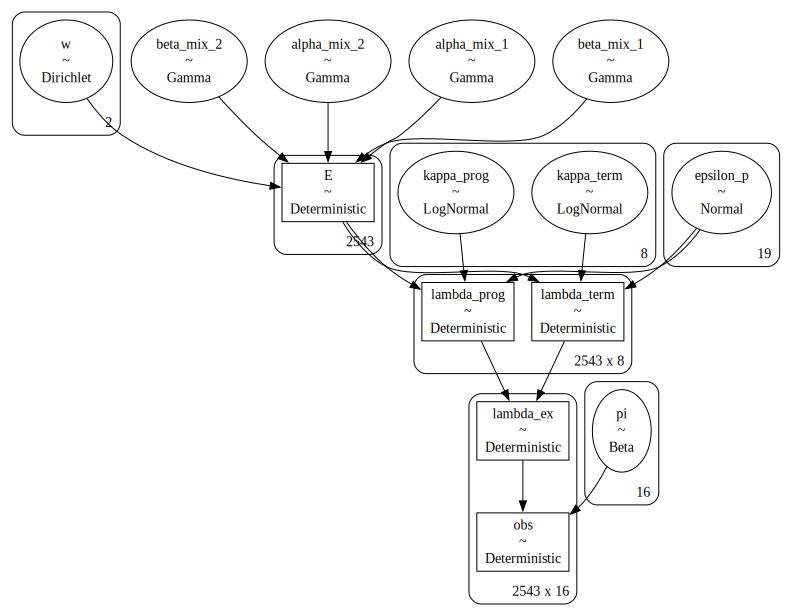

In [13]:
# Display the graphical representation of the model
graph_representation = pm.model_to_graphviz(model)
graph_representation

## Prior Predictive

In [14]:
with model:
    # Sample from the prior predictive
    prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=88)

In [15]:
# Extract prior predictive samples
# kappa_samples = prior_predictive.prior["kappa_g"].values.flatten()
kappa_prog_samples = prior_predictive.prior["kappa_prog"].values.flatten()
kappa_term_samples = prior_predictive.prior["kappa_term"].values.flatten()
lambda_ex_samples = prior_predictive.prior["lambda_ex"].values
lambda_prog_samples = prior_predictive.prior["lambda_prog"].values
lambda_term_samples = prior_predictive.prior["lambda_term"].values
pi_samples = prior_predictive.prior["pi"].values.flatten()
E_samples = prior_predictive.prior["E"].values.flatten()
epsilon_p_samples = prior_predictive.prior["epsilon_p"].values.flatten()

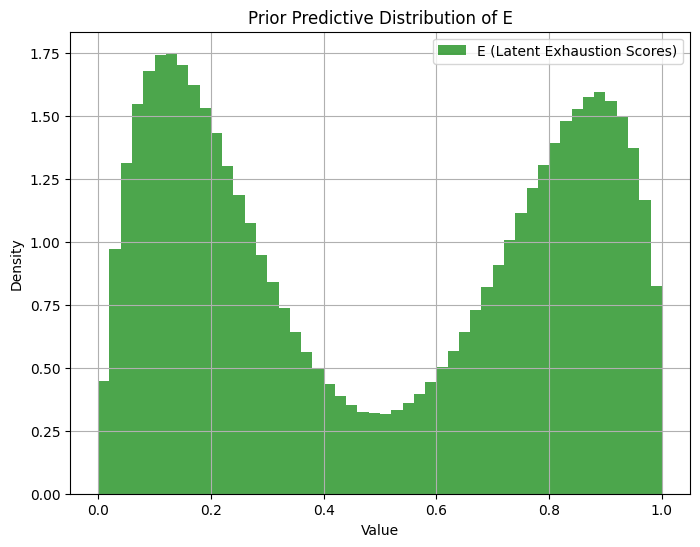

In [16]:
# plot prior predictive over E (Latent Exhaustion Scores)
plt.figure(figsize=(8, 6))
plt.hist(E_samples, bins=50, density=True, alpha=0.7, color="green", label="E (Latent Exhaustion Scores)")
plt.title("Prior Predictive Distribution of E")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

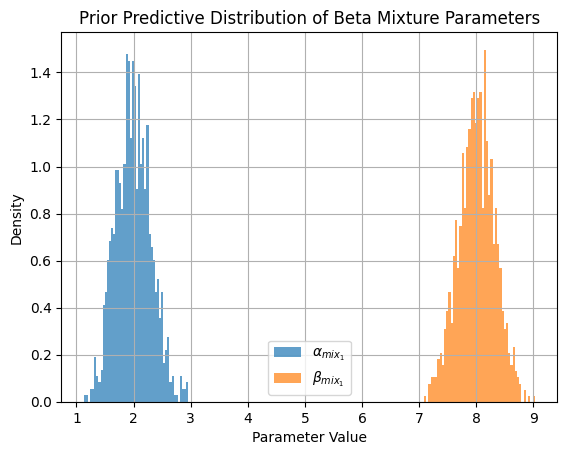

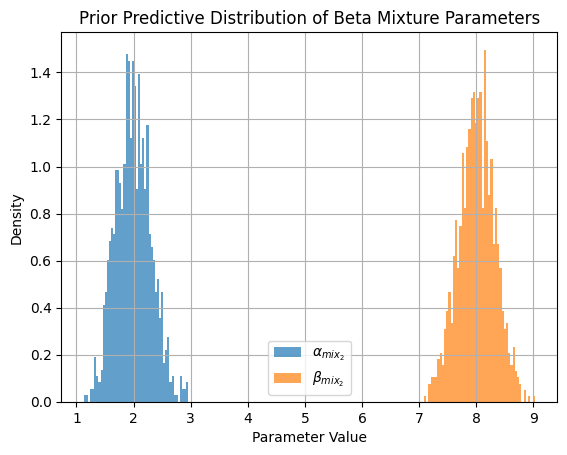

In [17]:
# plot prior predictive over Hyperpriors for E

# Extract and plot `alpha_mix_1`
alpha_mix_1_samples = prior_predictive.prior["alpha_mix_1"].values.flatten()
plt.hist(alpha_mix_1_samples, bins=50, density=True, alpha=0.7, label=r"$\alpha_{mix_1}$")

# Extract and plot `beta_mix_1`
beta_mix_1_samples = prior_predictive.prior["beta_mix_1"].values.flatten()
plt.hist(beta_mix_1_samples, bins=50, density=True, alpha=0.7, label=r"$\beta_{mix_1}$")

# Add titles and legend
plt.title("Prior Predictive Distribution of Beta Mixture Parameters")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


# Extract and plot `alpha_mix_2`
alpha_mix_2_samples = prior_predictive.prior["alpha_mix_2"].values.flatten()
plt.hist(alpha_mix_1_samples, bins=50, density=True, alpha=0.7, label=r"$\alpha_{mix_2}$")

# Extract and plot `beta_mix_2`
beta_mix_2_samples = prior_predictive.prior["beta_mix_2"].values.flatten()
plt.hist(beta_mix_1_samples, bins=50, density=True, alpha=0.7, label=r"$\beta_{mix_2}$")

# Add titles and legend
plt.title("Prior Predictive Distribution of Beta Mixture Parameters")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

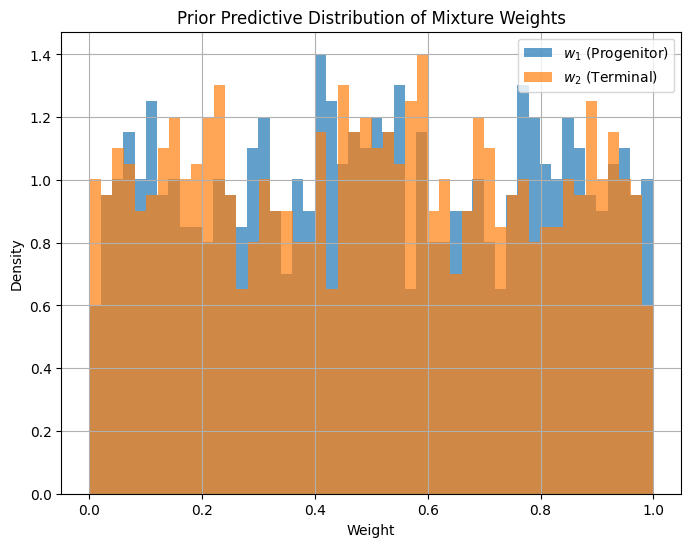

In [18]:
# plot prior predictive over Weights hyperprior for E beta mixtures

# Extract weights for both components
w_samples = prior_predictive.prior["w"].values  # Shape: (1, 1000, 2)

# Plot the weights
plt.figure(figsize=(8, 6))
plt.hist(w_samples[:, :, 0].flatten(), bins=50, density=True, alpha=0.7, label=r"$w_1$ (Progenitor)")
plt.hist(w_samples[:, :, 1].flatten(), bins=50, density=True, alpha=0.7, label=r"$w_2$ (Terminal)")

plt.title("Prior Predictive Distribution of Mixture Weights")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


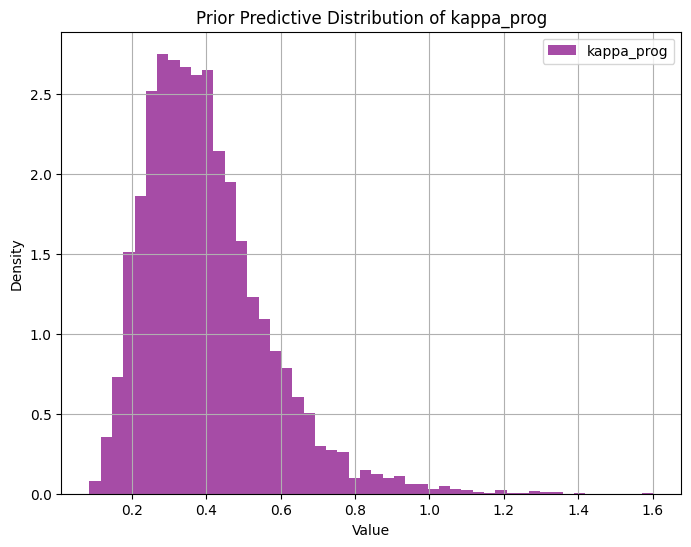

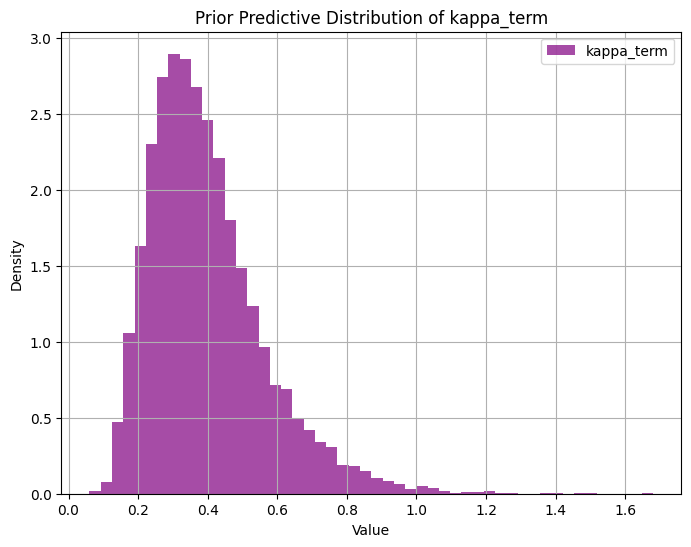

In [19]:
# plot prior predictive over kappa

# plot kappa_prog samples
plt.figure(figsize=(8, 6))
plt.hist(kappa_prog_samples, bins=50, density=True, alpha=0.7, color="purple", label="kappa_prog")
plt.title("Prior Predictive Distribution of kappa_prog")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# Plot kappa_term samples
plt.figure(figsize=(8, 6))
plt.hist(kappa_term_samples, bins=50, density=True, alpha=0.7, color="purple", label="kappa_term")
plt.title("Prior Predictive Distribution of kappa_term")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

/home/jupyter-me1117/CD8_Exhaustion_MCMC/CD8ExhaustionHierBayes/CD8ExhaustionHierBayes_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


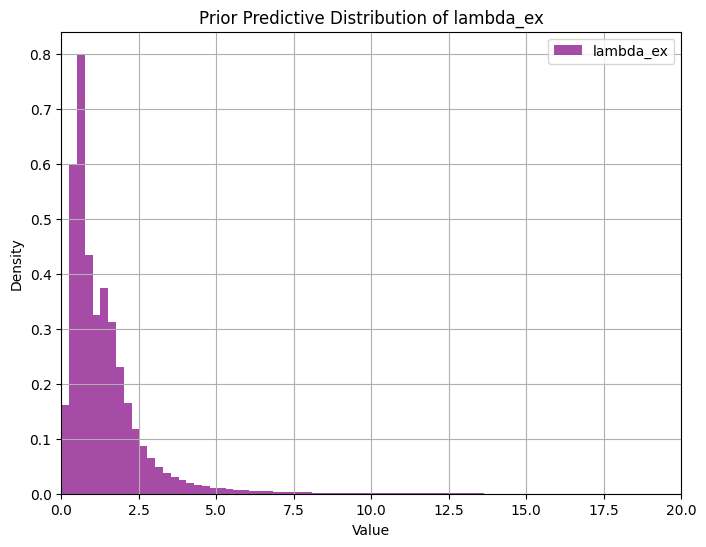

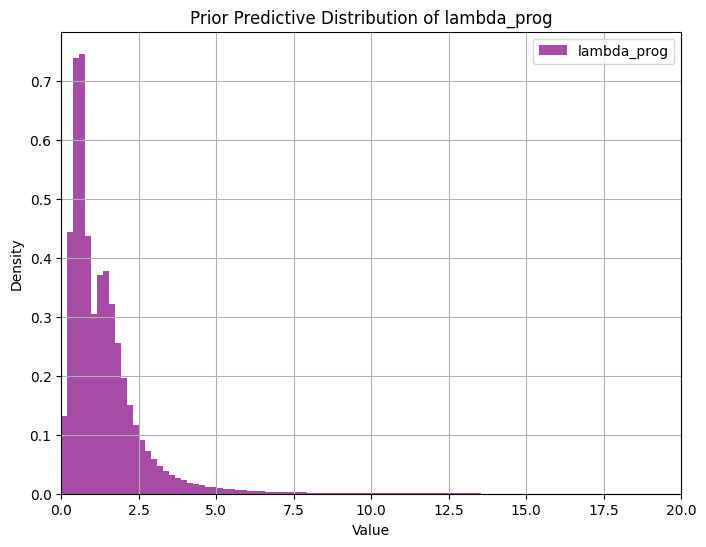

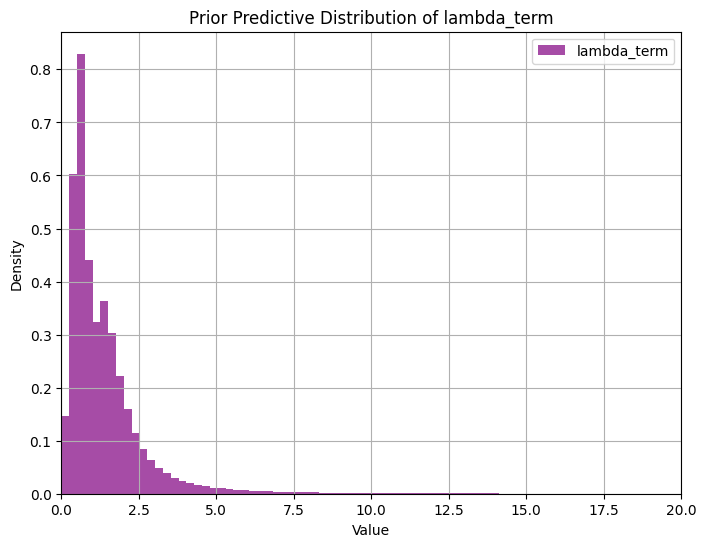

In [25]:
# plot prior predictive over Lambdas (gene expression rate)

# Flatten samples
lambda_ex_flat = lambda_ex_samples.flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.hist(lambda_ex_flat, bins=10000, density=True, alpha=0.7, color="purple", label="lambda_ex")
plt.title("Prior Predictive Distribution of lambda_ex")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.show()


# Flatten samples
lambda_prog_flat = lambda_prog_samples.flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.hist(lambda_prog_flat, bins=10000, density=True, alpha=0.7, color="purple", label="lambda_prog")
plt.title("Prior Predictive Distribution of lambda_prog")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.show()


# Flatten samples
lambda_term_flat = lambda_term_samples.flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.hist(lambda_term_flat, bins=10000, density=True, alpha=0.7, color="purple", label="lambda_term")
plt.title("Prior Predictive Distribution of lambda_term")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.show()

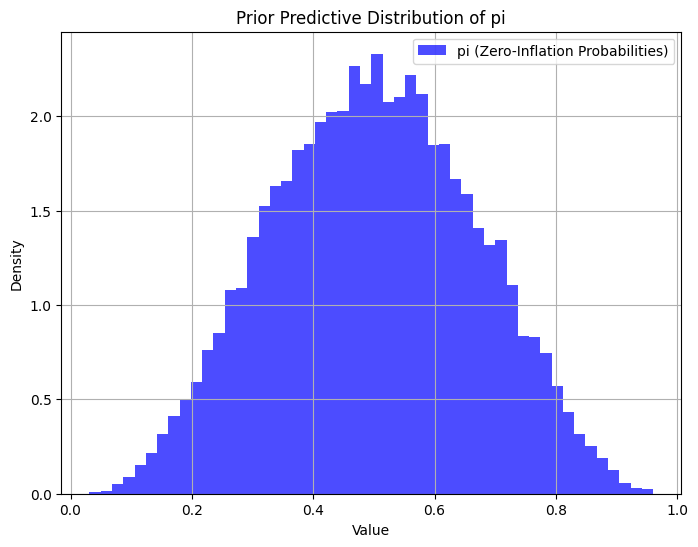

In [21]:
# plot prior predictive over pi (zero-inflation probabilities)
plt.figure(figsize=(8, 6))
plt.hist(pi_samples, bins=50, density=True, alpha=0.7, color="blue", label="pi (Zero-Inflation Probabilities)")
plt.title("Prior Predictive Distribution of pi")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

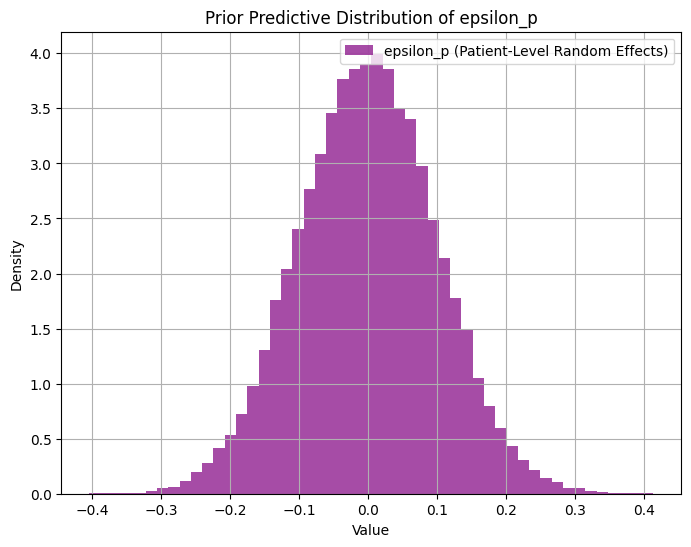

In [22]:
# plot prior predictive over epsilon_p (Patient-Level Random Effects)
plt.figure(figsize=(8, 6))
plt.hist(epsilon_p_samples, bins=50, density=True, alpha=0.7, color="purple", label="epsilon_p (Patient-Level Random Effects)")
plt.title("Prior Predictive Distribution of epsilon_p")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

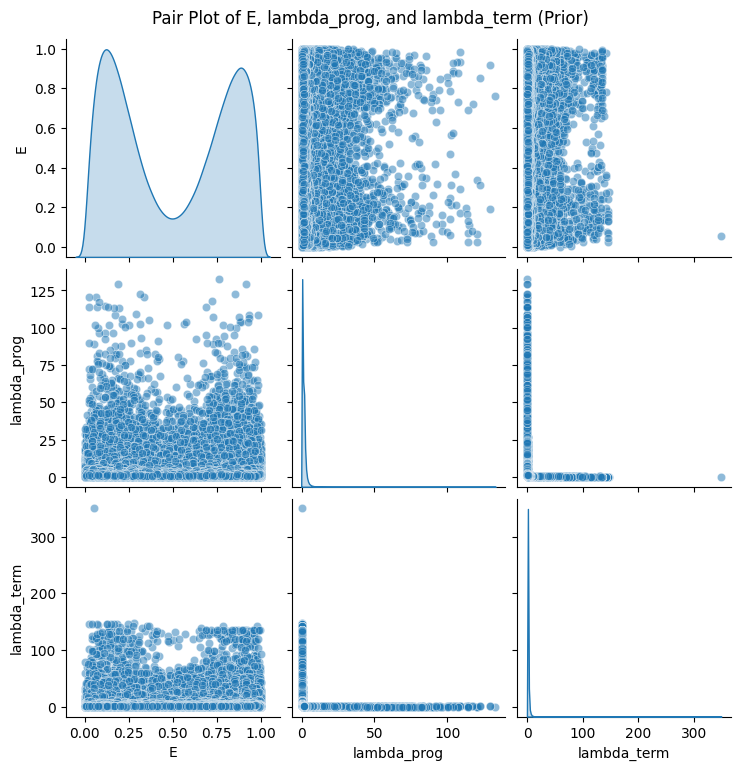

In [23]:
# Pair Plots of lambda and E

# Extract prior predictive samples
E_prior = prior_predictive.prior["E"].values.flatten()  # Flatten E values
lambda_prog_prior = prior_predictive.prior["lambda_prog"].values.flatten()
lambda_term_prior = prior_predictive.prior["lambda_term"].values.flatten()

# Create a DataFrame for the pair plot
prior_df = pd.DataFrame({
    "E": E_prior,
    "lambda_prog": lambda_prog_prior[:len(E_prior)],  # Match dimensions with E
    "lambda_term": lambda_term_prior[:len(E_prior)],  # Match dimensions with E
})

# Create the pair plot
sns.pairplot(prior_df, diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Pair Plot of E, lambda_prog, and lambda_term (Prior)", y=1.02)
plt.show()

## Sampling

In [31]:
# Sample
with model:
    trace = pm.sample(
        draws=3000,  # Number of samples to draw per chain
        tune=5000,    # Number of tuning steps per chain
        chains=4,    # Sample from 4 chains
        cores=4,    # 4 cores are available
        target_accept=0.99,  # Higher target_accept for more complex models
        return_inferencedata=True,  # Return as an ArviZ InferenceData object
        random_seed=232  # Set random seed for reproducibility
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha_mix_1, beta_mix_1, alpha_mix_2, beta_mix_2, E, pi, kappa_prog, kappa_term, epsilon_p]
/home/jupyter-me1117/CD8_Exhaustion_MCMC/CD8ExhaustionHierBayes/CD8ExhaustionHierBayes_venv/lib/python3.9/site-packages/pymc/aesaraf.py:387: UserWarning: No value variable found for beta_rv{0, (0, 0), floatX, False}.out; the random variable will not be replaced.
  warnings.warn(


Sampling 4 chains for 5_000 tune and 3_000 draw iterations (20_000 + 12_000 draws total) took 3710 seconds.


In [32]:
# Save the trace to a NetCDF file
az.to_netcdf(trace, "./output/trace.nc")

# Load the trace from the NetCDF file
# trace = az.from_netcdf("./output/trace.nc")

'./output/trace_232.nc'

## Posterior Predictive

In [26]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["obs"], random_seed=23)

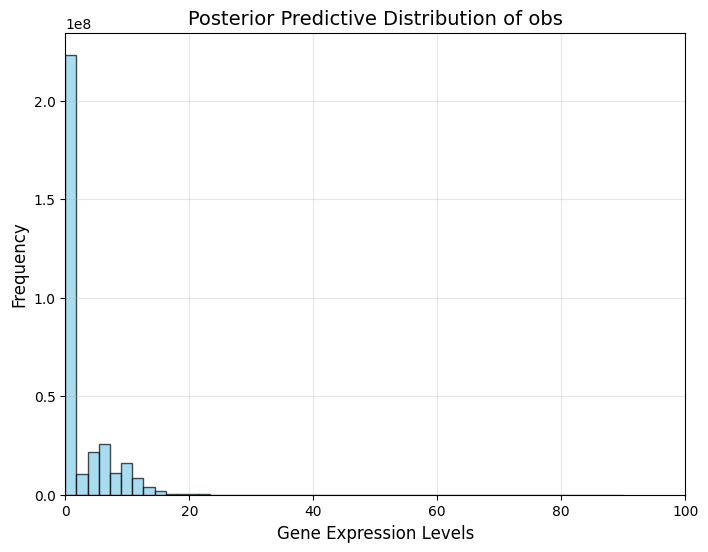

In [27]:
# Flatten posterior predictive samples for `obs`
obs_pp = posterior_predictive.posterior_predictive["obs"].values.flatten()

# Plot the posterior predictive distribution
plt.figure(figsize=(8, 6))
plt.hist(obs_pp, bins=50, alpha=0.7, color="skyblue", edgecolor="k")
plt.title("Posterior Predictive Distribution of obs", fontsize=14)
plt.xlabel("Gene Expression Levels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, 100)
plt.show()

## Posterior

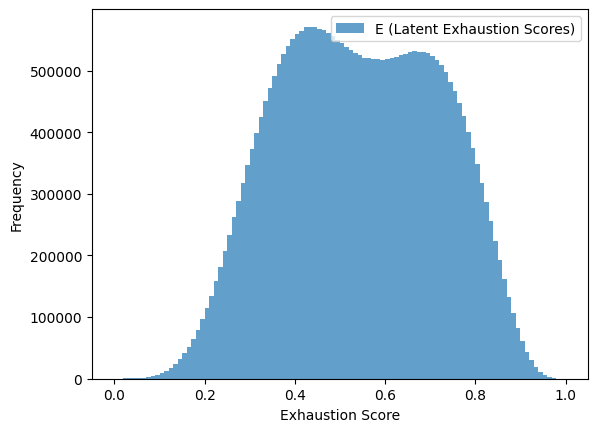

In [33]:
# Plot posterior over E
plt.hist(trace.posterior["E"].values.flatten(), bins=100, alpha=0.7, label="E (Latent Exhaustion Scores)")
plt.xlabel("Exhaustion Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

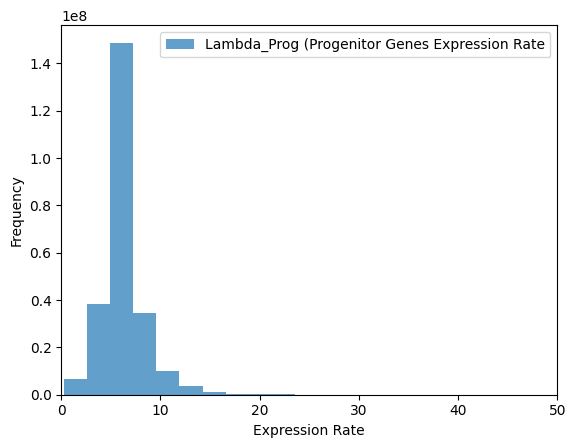

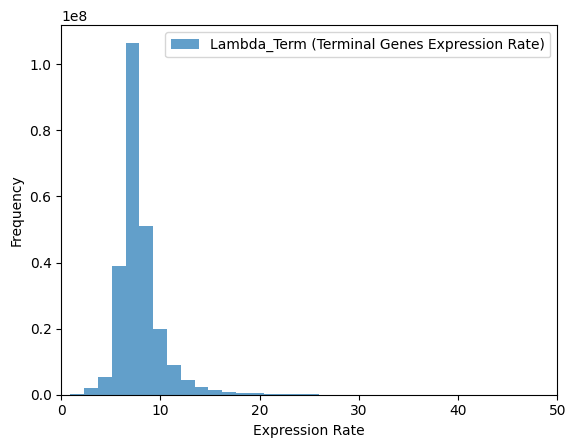

In [34]:
# Plot posterior over lambda_prog
plt.hist(trace.posterior["lambda_prog"].values.flatten(), bins=50, alpha=0.7, label="Lambda_Prog (Progenitor Genes Expression Rate")
plt.xlabel("Expression Rate")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0, 50)
plt.show()

# Plot posterior over lambda_term
plt.hist(trace.posterior["lambda_term"].values.flatten(), bins=50, alpha=0.7, label="Lambda_Term (Terminal Genes Expression Rate)")
plt.xlabel("Expression Rate")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0, 50)
plt.show()

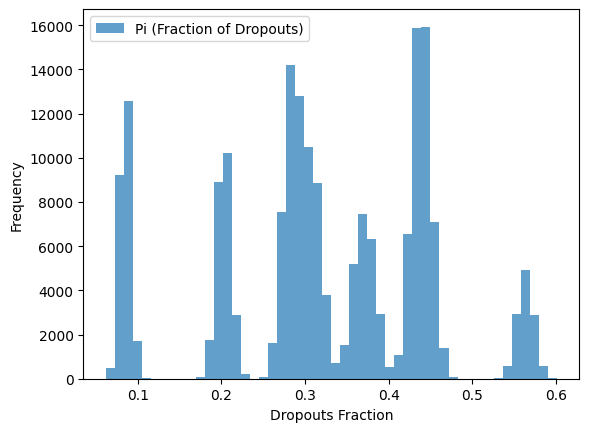

In [35]:
# Plot posterior over Pi
plt.hist(trace.posterior["pi"].values.flatten(), bins=50, alpha=0.7, label="Pi (Fraction of Dropouts)")
plt.xlabel("Dropouts Fraction")
plt.ylabel("Frequency")
plt.legend()
plt.show()

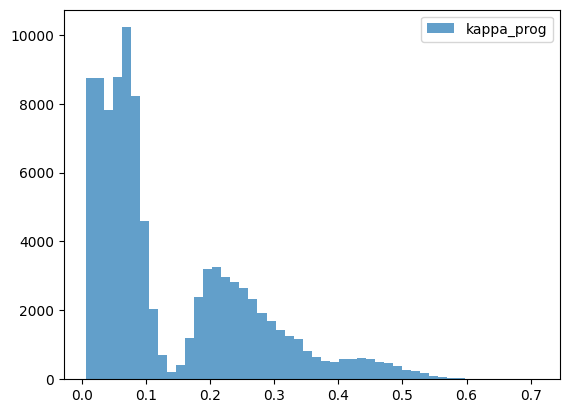

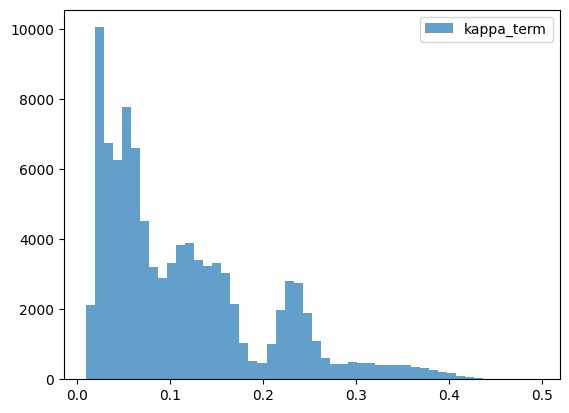

In [36]:
# Plot posterior over kappa prog
plt.hist(trace.posterior["kappa_prog"].values.flatten(), bins=50, alpha=0.7, label="kappa_prog")
# plt.hist(trace.posterior["kappa_term"].values.flatten(), bins=50, alpha=0.7, label="kappa_term")
plt.legend()
plt.show()

# Plot posterior over kappa term
plt.hist(trace.posterior["kappa_term"].values.flatten(), bins=50, alpha=0.7, label="kappa_term")
plt.legend()
plt.show()

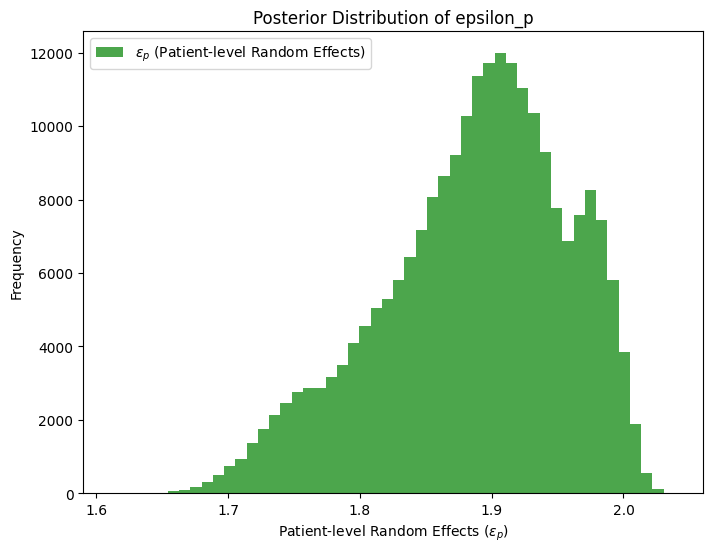

In [37]:
# Plot posterior over epsilon_p
plt.figure(figsize=(8, 6))
plt.hist(trace.posterior["epsilon_p"].values.flatten(), bins=50, alpha=0.7, color="green", label=r"$\epsilon_p$ (Patient-level Random Effects)")
plt.xlabel(r"Patient-level Random Effects ($\epsilon_p$)")
plt.ylabel("Frequency")
plt.title("Posterior Distribution of epsilon_p")
plt.legend()
plt.show()

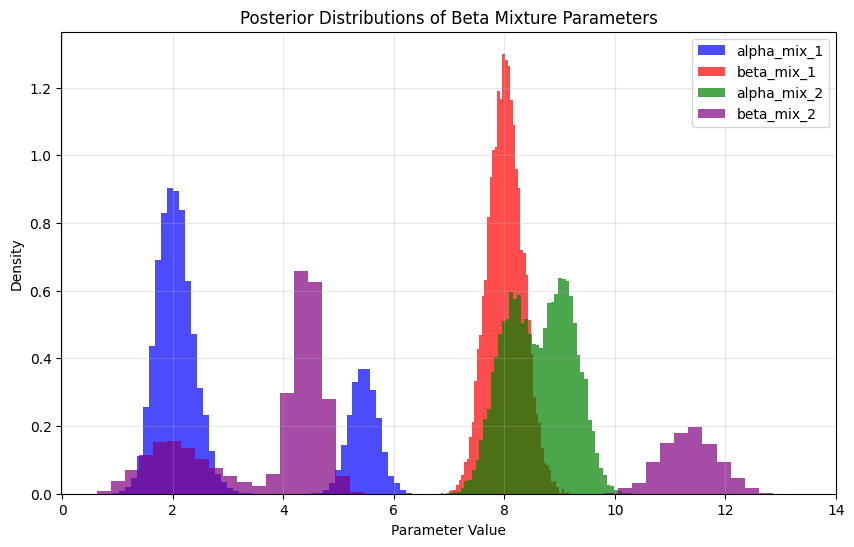

In [38]:
# Plot posterior over gamma parameters of the E Beta mixture

# Extract values for the Gamma parameters of the Beta Mixture
alpha_mix_1_vals = trace.posterior["alpha_mix_1"].values.flatten()
beta_mix_1_vals = trace.posterior["beta_mix_1"].values.flatten()
alpha_mix_2_vals = trace.posterior["alpha_mix_2"].values.flatten()
beta_mix_2_vals = trace.posterior["beta_mix_2"].values.flatten()

# Plot the posterior distributions
plt.figure(figsize=(10, 6))

# Alpha_mix_1
plt.hist(alpha_mix_1_vals, bins=50, alpha=0.7, label="alpha_mix_1", color="blue", density=True)
# Beta_mix_1
plt.hist(beta_mix_1_vals, bins=50, alpha=0.7, label="beta_mix_1", color="red", density=True)
# Alpha_mix_2
plt.hist(alpha_mix_2_vals, bins=50, alpha=0.7, label="alpha_mix_2", color="green", density=True)
# Beta_mix_2
plt.hist(beta_mix_2_vals, bins=50, alpha=0.7, label="beta_mix_2", color="purple", density=True)

# Add labels and legend
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.title("Posterior Distributions of Beta Mixture Parameters")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

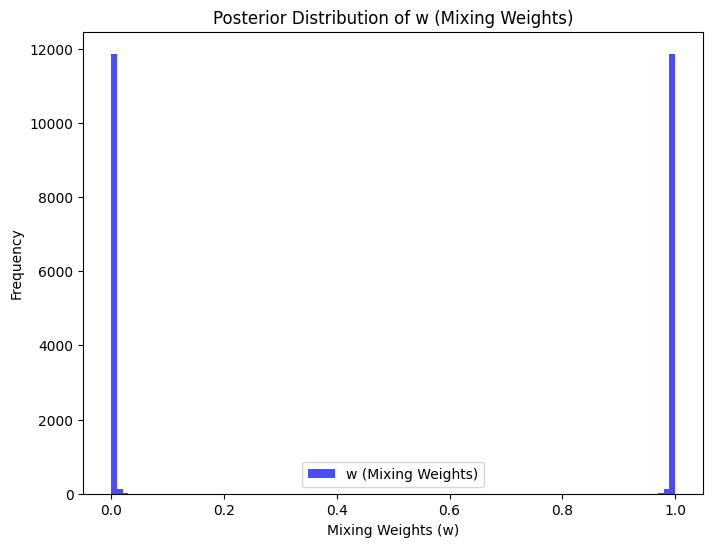

In [39]:
# Plot posterior over w (weights of the E beta mixtures)
plt.figure(figsize=(8, 6))
plt.hist(trace.posterior["w"].values.flatten(), bins=100, alpha=0.7, color="blue", label="w (Mixing Weights)")
plt.xlabel("Mixing Weights (w)")
plt.ylabel("Frequency")
plt.title("Posterior Distribution of w (Mixing Weights)")
plt.legend()
plt.show()

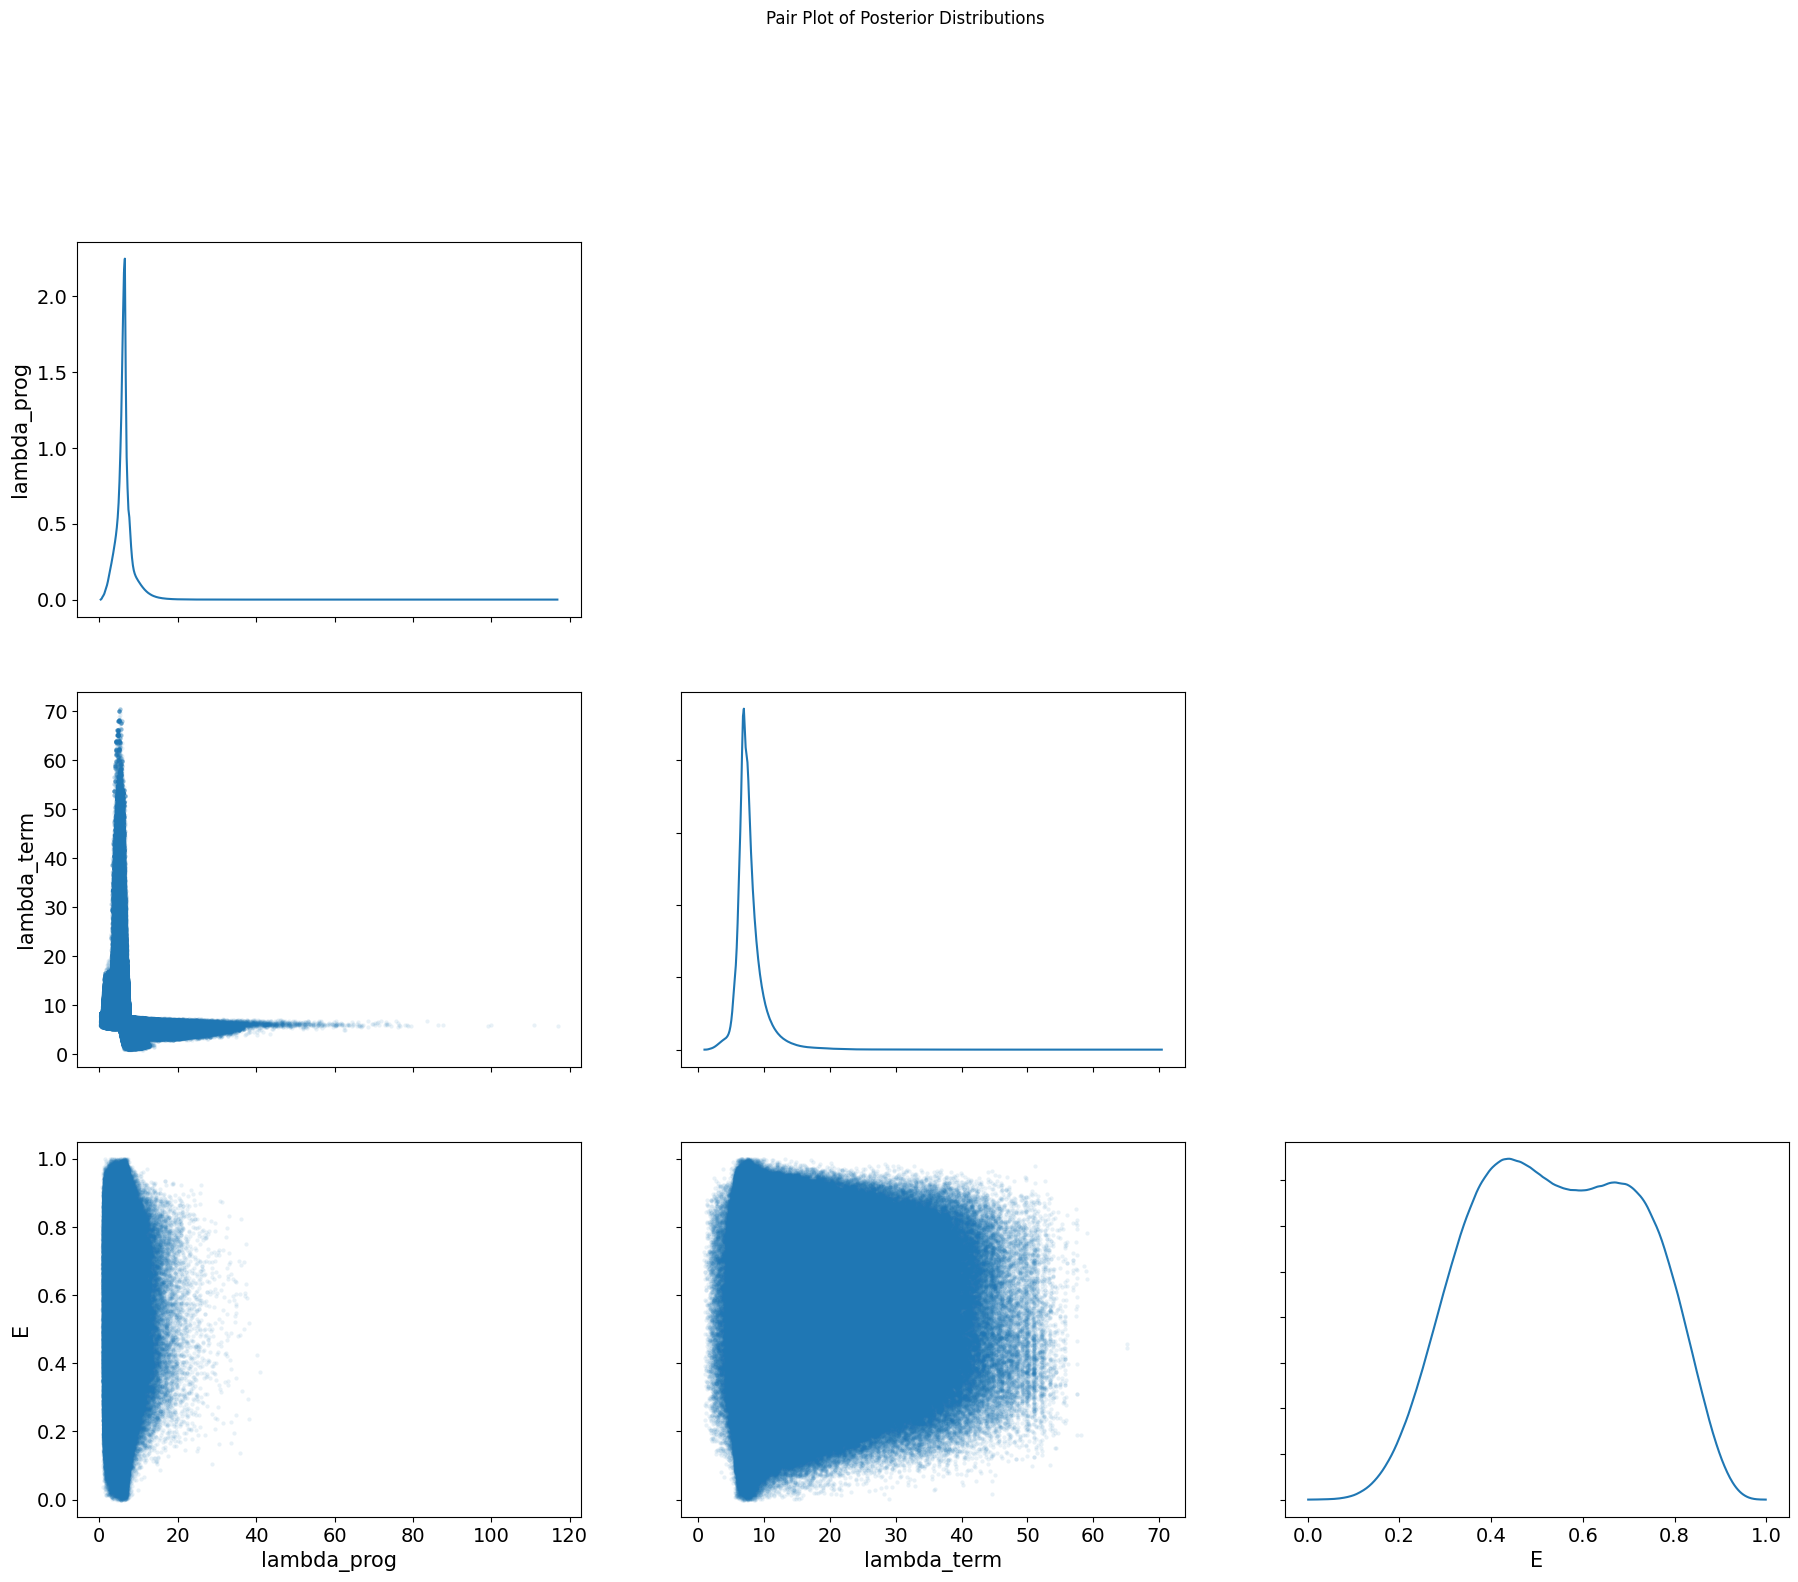

In [40]:
# Pair Plot over lambdas and E

# Extract posterior samples for lambda_prog, lambda_term, and E
lambda_prog_samples = trace.posterior["lambda_prog"].values.flatten()
lambda_term_samples = trace.posterior["lambda_term"].values.flatten()
E_samples = trace.posterior["E"].values.flatten()

# Convert to InferenceData
posterior_dict = {
    "lambda_prog": lambda_prog_samples,
    "lambda_term": lambda_term_samples,
    "E": E_samples,
}
posterior_idata = az.from_dict(posterior=posterior_dict)

# Plot the pair plot
ax = az.plot_pair(
    posterior_idata,
    var_names=["lambda_prog", "lambda_term", "E"],
    marginals=True,
    kind="scatter",
    scatter_kwargs={"alpha": 0.1, "color": "C0"},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", "alpha": 1}},
)

# Add a title
plt.suptitle("Pair Plot of Posterior Distributions", y=1.02)
plt.show()

## Diagnostics and Statistics

In [28]:
# Generate the Summary Stats and Diagnostics (Mean, SD, ESS, MCSE, rhat,..etc)
summary_trace = az.summary(trace, var_names=[
    'epsilon_p', 'pi', 'E', 'lambda_prog', 'lambda_term', 'lambda_ex', 'kappa_prog', 'kappa_term'])

# Save to a CSV file
summary_trace.to_csv("./output/summary_trace.csv")

/home/jupyter-me1117/CD8_Exhaustion_MCMC/CD8ExhaustionHierBayes/CD8ExhaustionHierBayes_venv/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (40688) in plot_rank, generating only 40 plots
  warnings.warn(
/home/jupyter-me1117/CD8_Exhaustion_MCMC/CD8ExhaustionHierBayes/CD8ExhaustionHierBayes_venv/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2543) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'epsilon_p\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'epsilon_p\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'epsilon_p\n8'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n9'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'epsilon_p\n10'}, xlabel='

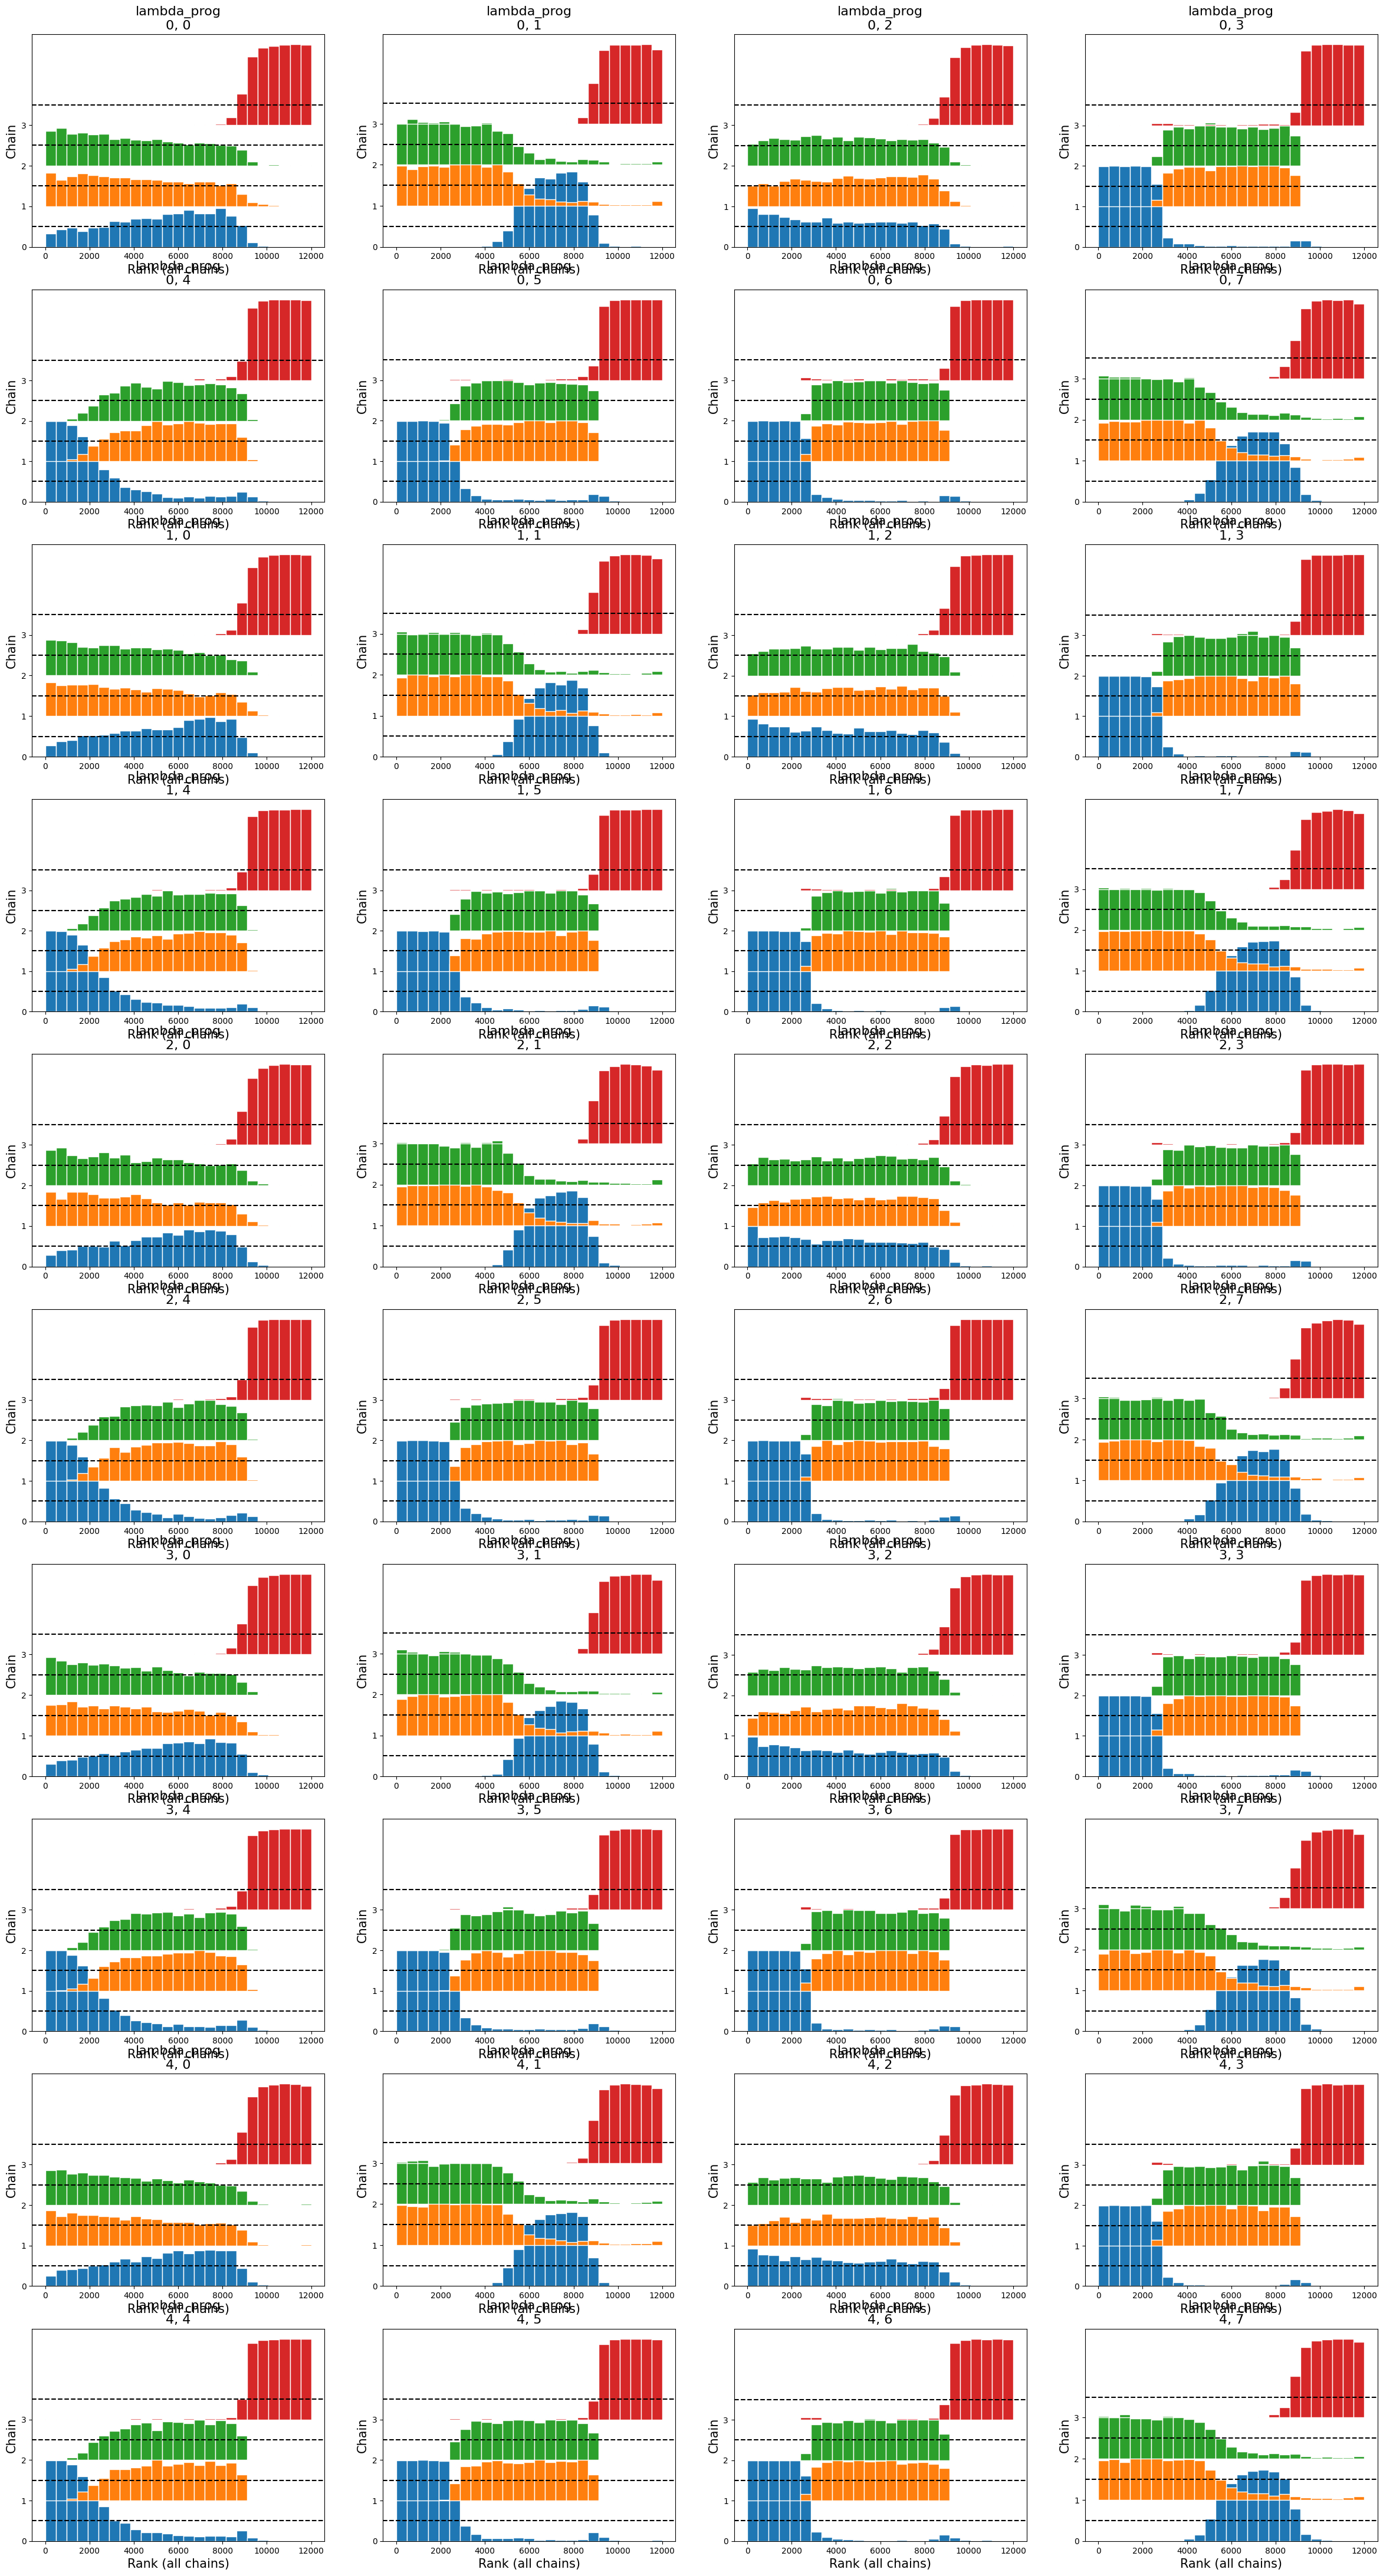

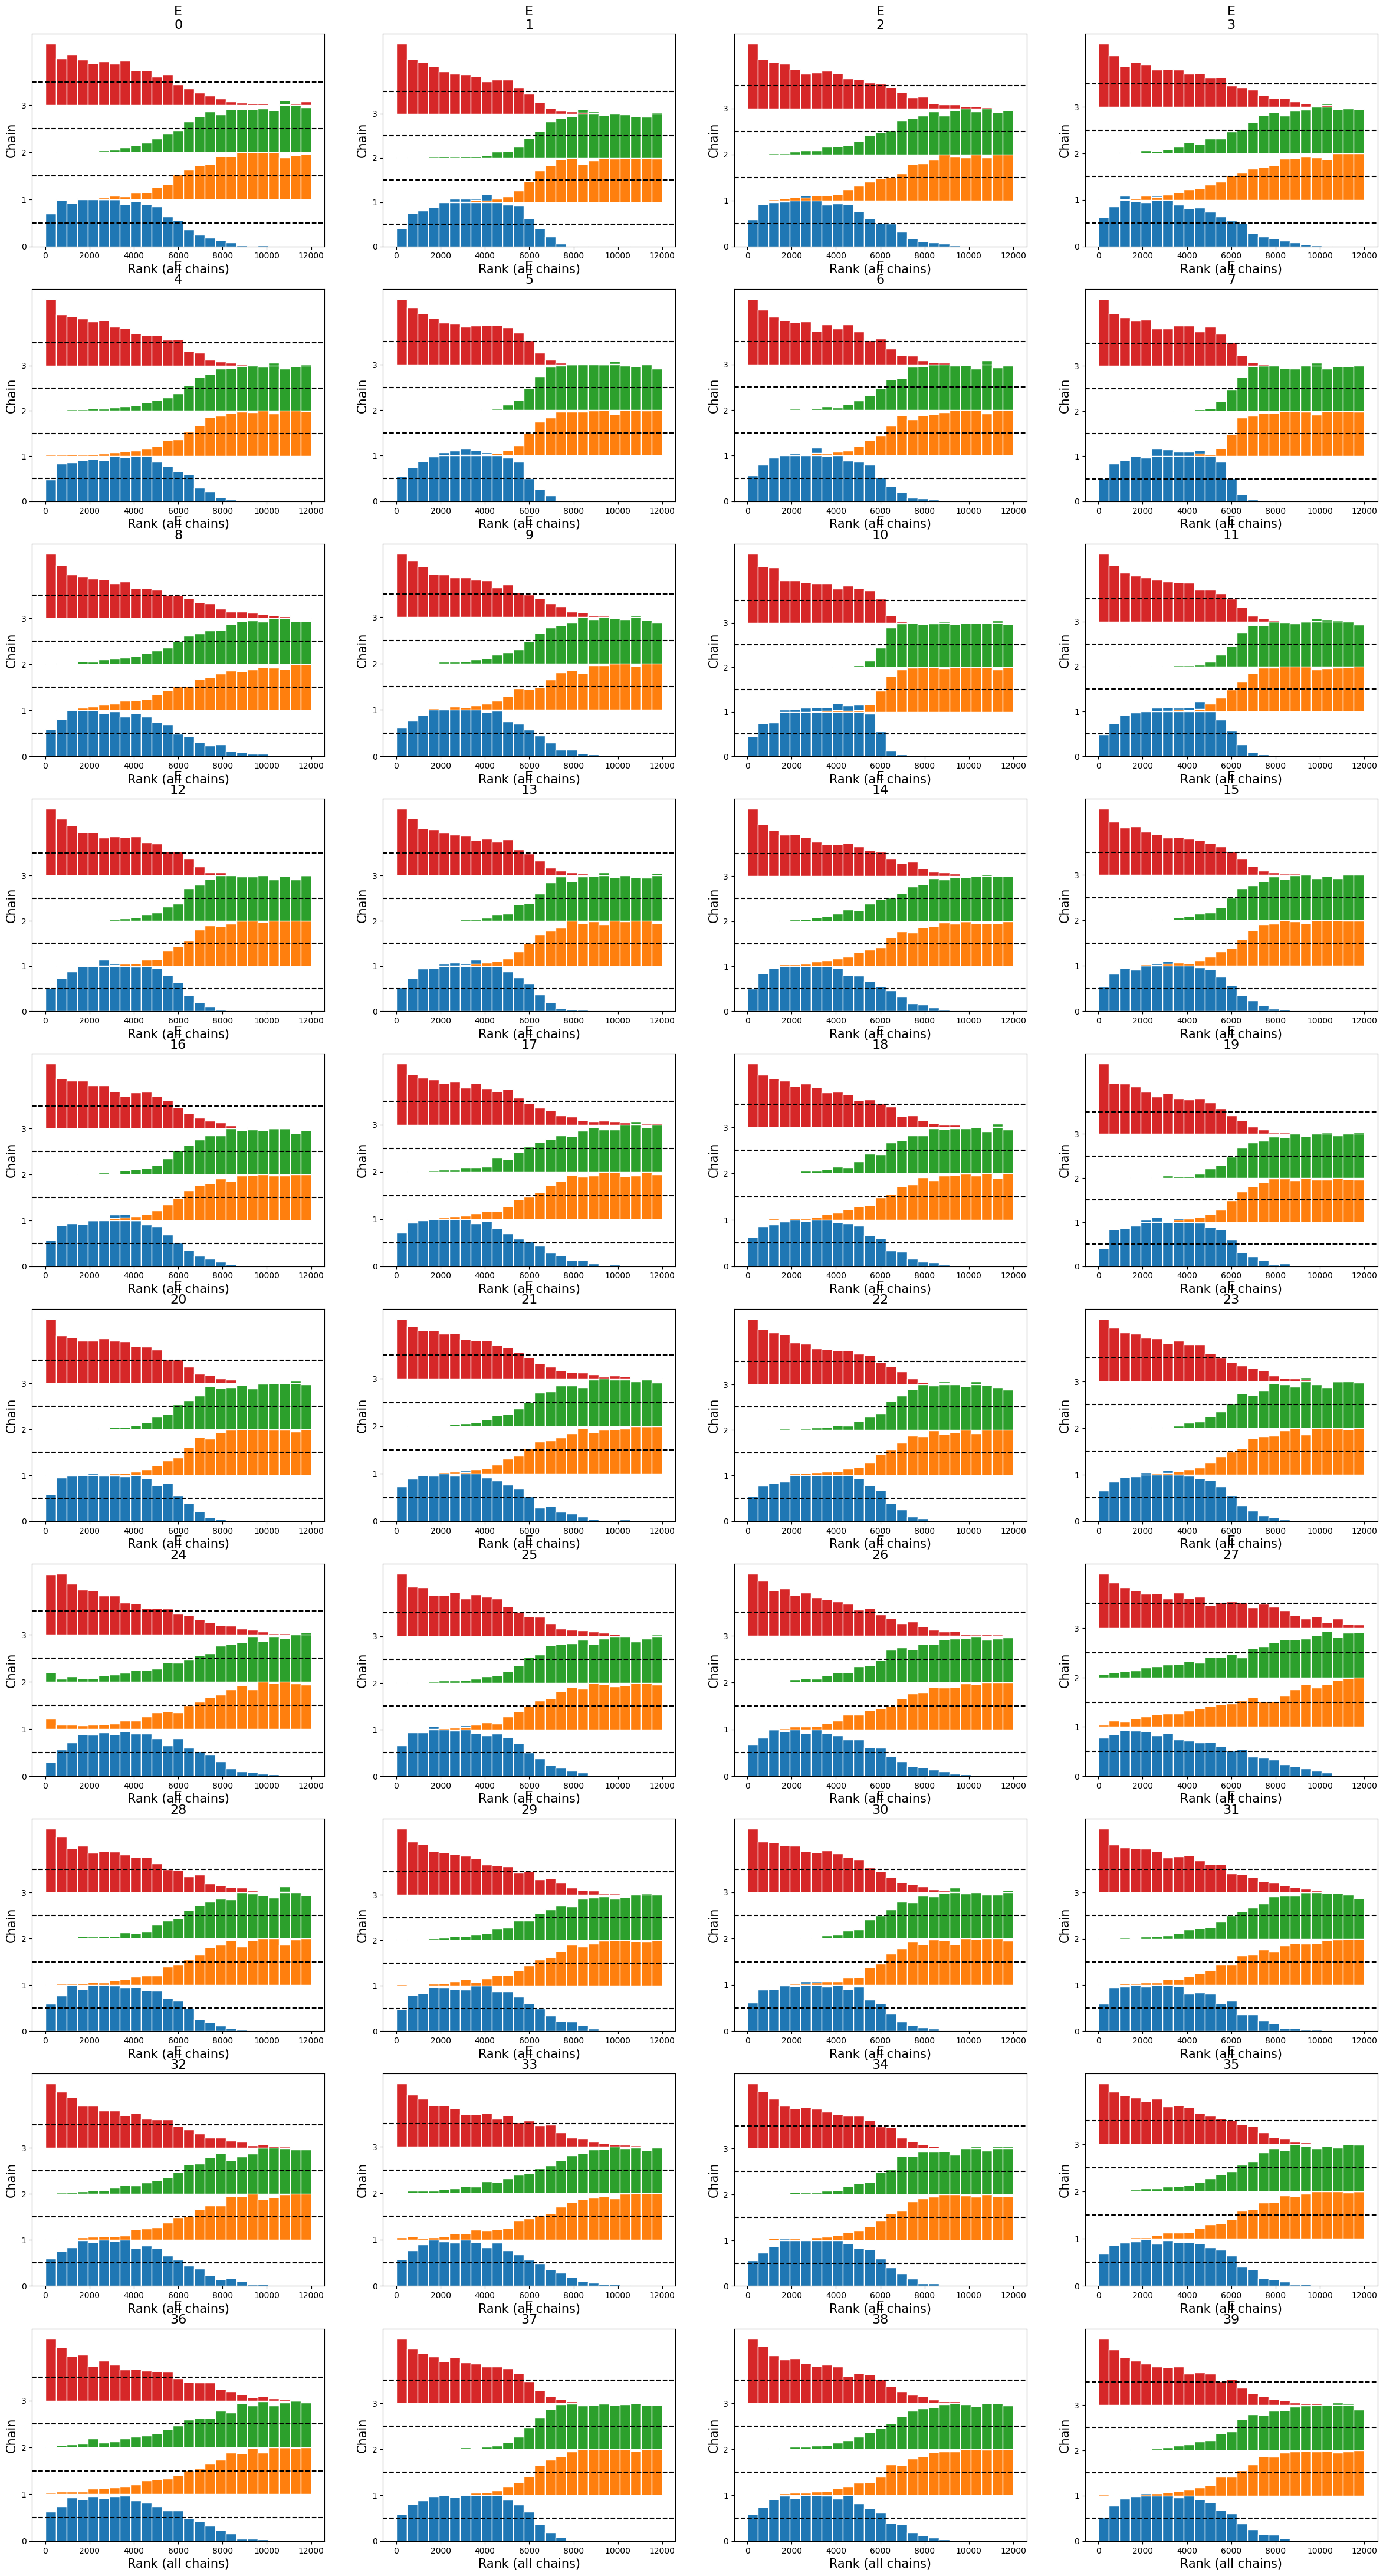

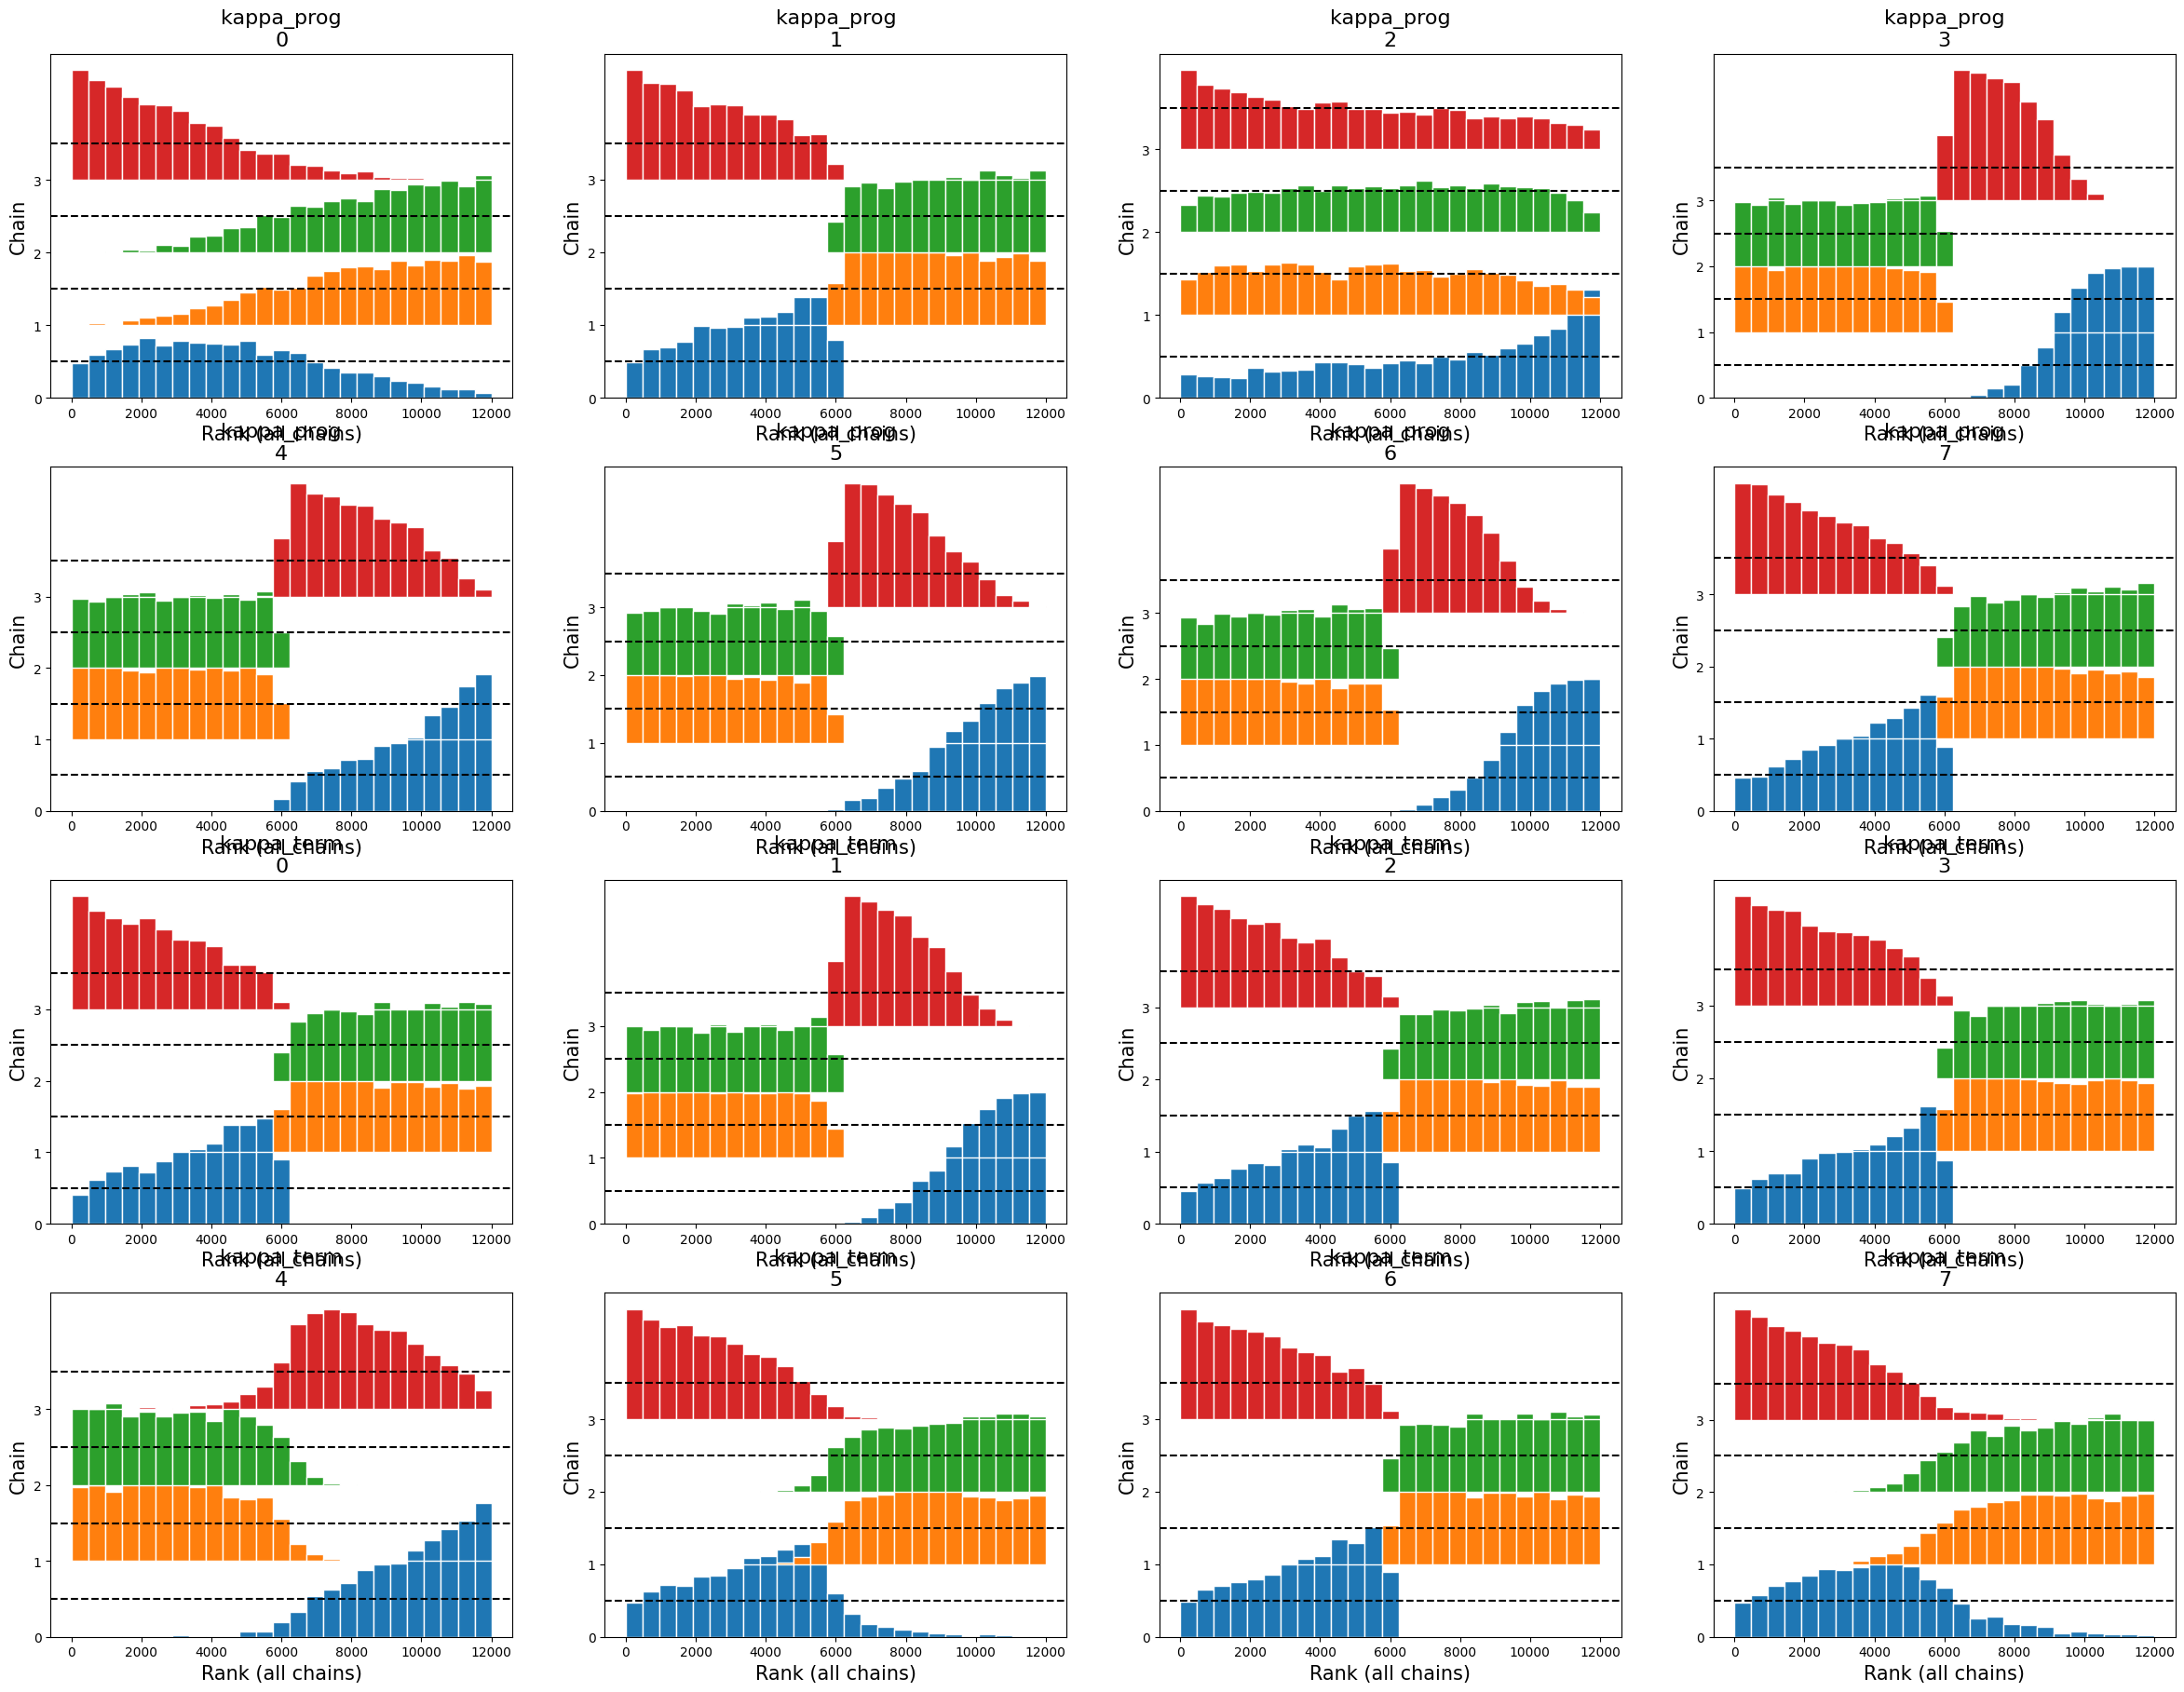

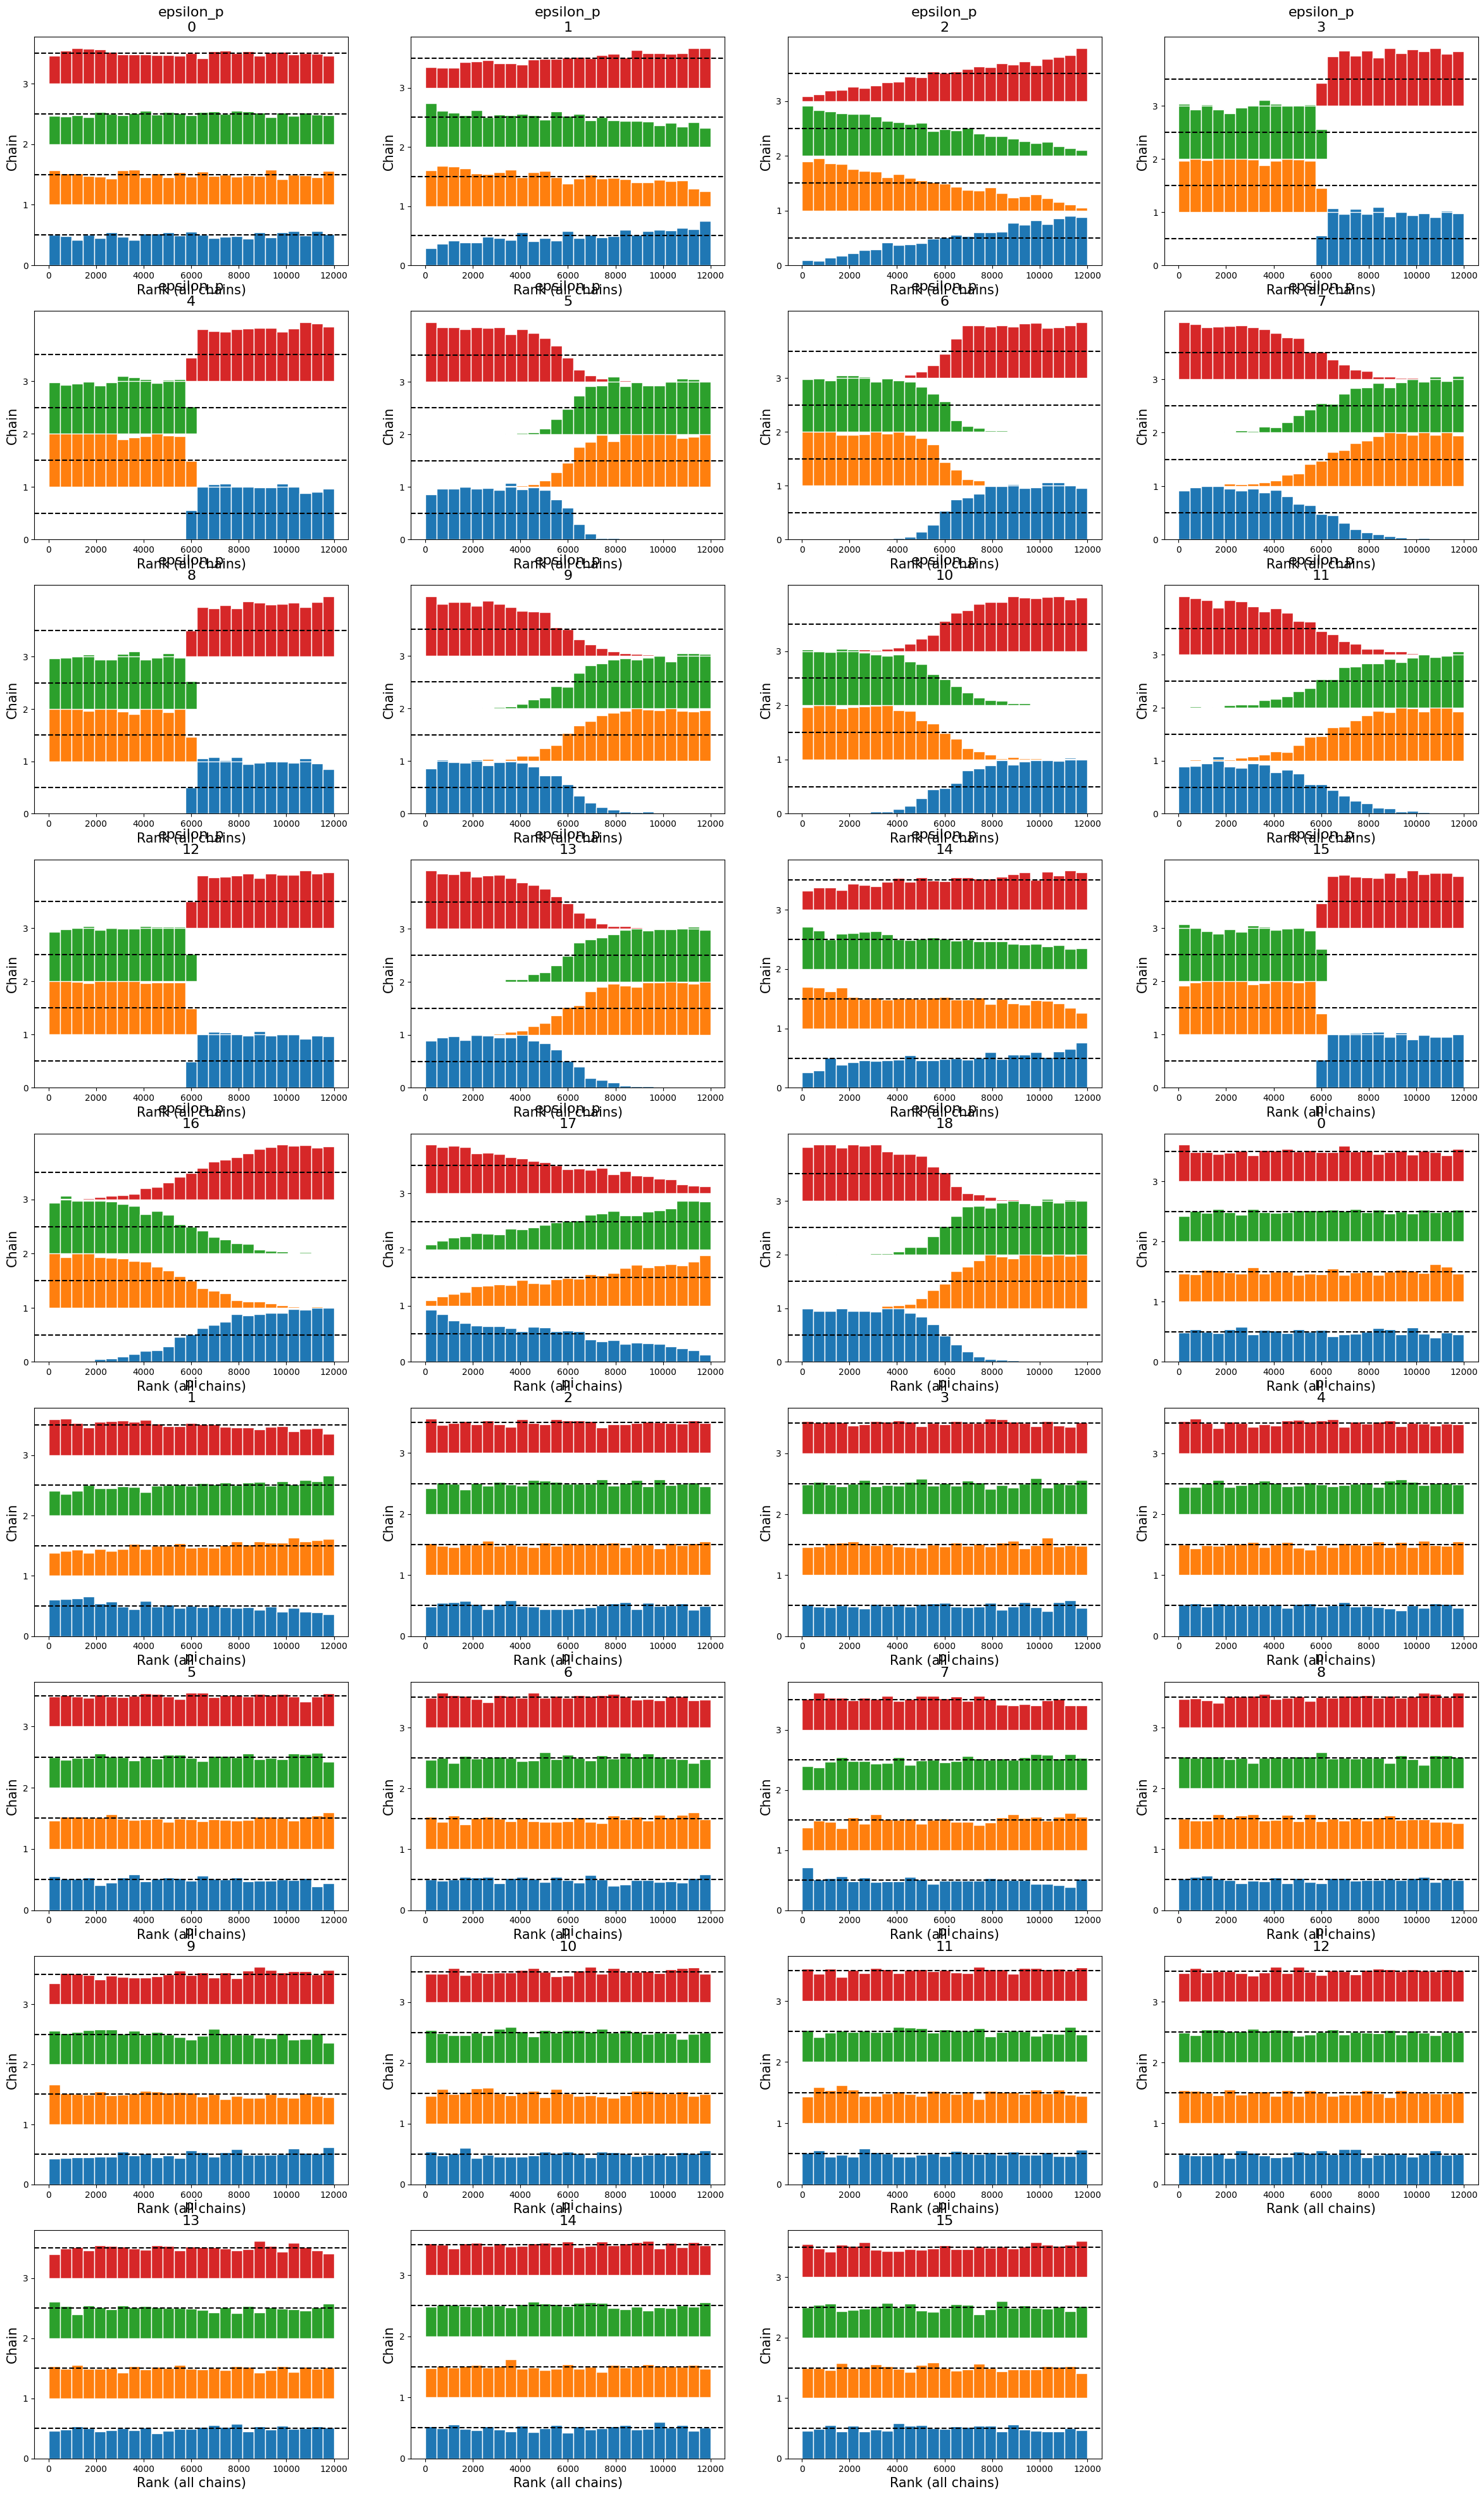

In [41]:
# histograms of the ranked posterior draws (ranked over all chains) plotted separately for each chain. 
az.plot_rank(trace, var_names=['lambda_prog', 'lambda_term'])
az.plot_rank(trace, var_names=['E'])
az.plot_rank(trace, var_names=['kappa_prog', 'kappa_term'])
az.plot_rank(trace, var_names=['epsilon_p', 'pi'])